In [8]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [20]:
import scipy.io.wavfile
from scipy.fftpack import dct

def read_file (fname = '/Users/nishant/Downloads/OSR.wav'):
    sample_rate, signal = scipy.io.wavfile.read(fname)  # File assumed to be in the same directory
    print sample_rate, signal, signal.shape
    signal = signal[0:int(3.5 * sample_rate)]  # Keep the first 3.5 seconds
    print signal.shape
    return sample_rate, signal

In [21]:
def plot_wav (audio):
    plt.plot(audio)
    # label the axes
    plt.ylabel("Amplitude")
    plt.xlabel("Time")
    # set the title  
    #plt.title("Sample Wav")
    # display the plot
    plt.show()

8000 [ -919 -1314 -1049 ...,  -330  -320  -300] (268985,)
(28000,)


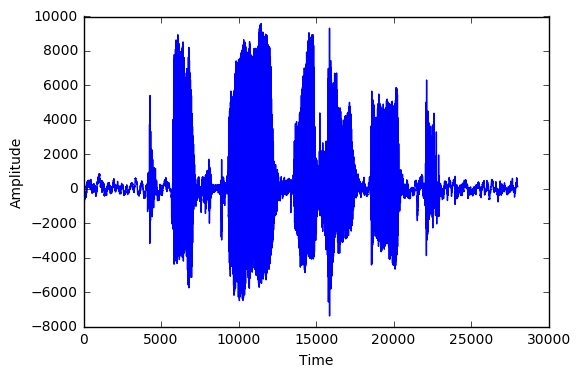

In [22]:
sample_rate, signal = read_file()
plot_wav(signal)

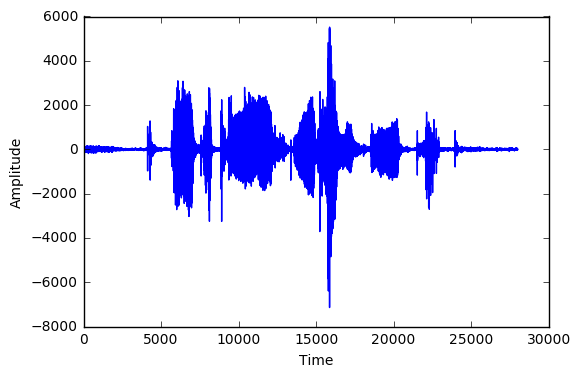

In [24]:
# Pre-emphasis filter y(t)=x(t)−αx(t−1) -- not necessary if normalization done
#1. improve SNR 2. reduce FFT numerical errors 3. balance high/lower freq (inc high freq)
pre_emphasis = 0.97
emphasized_signal = numpy.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])
plot_wav (emphasized_signal)


In [25]:
#Framing - split signal into short frames = don't do FFT across whole signal; signal freq change over time
#assume freq signal stationary over short time period

#Typical frame sizes from 20 ms to 40 ms with 50% (+/-10%) overlap between consecutive frames. 
#Popular settings are 25 ms for the frame size, 
#frame_size = 0.025 and a 10 ms stride (15 ms overlap), frame_stride = 0.01

#Overlapping these windows allows us to control the time resolution at the cost of increasing the data size.

In [37]:
def compute_frames (signal, frame_size = 0.025, frame_stride = 0.01):
    frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate  # Convert from seconds to samples
    signal_length = len(signal)
    frame_length = int(round(frame_length))
    frame_step = int(round(frame_step))
    num_frames = int(numpy.ceil(float(numpy.abs(signal_length - frame_length)) / frame_step))  # Make sure that we have at least 1 frame

    pad_signal_length = num_frames * frame_step + frame_length
    z = numpy.zeros((pad_signal_length - signal_length))
    pad_signal = numpy.append(emphasized_signal, z) # Pad Signal to make sure that all frames have equal number of samples without truncating any samples from the original signal

    indices = numpy.tile(numpy.arange(0, frame_length), (num_frames, 1)) + numpy.tile(numpy.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
    frames = pad_signal[indices.astype(numpy.int32, copy=False)]
    return frames, frame_length

In [38]:
frames, frame_length = compute_frames (emphasized_signal)
print frames.shape, frame_length

(348, 200) 200


In [40]:
# apply windowing function w[n]=0.54−0.46cos(2πn/N−1)
# counteract the assumption made by the FFT that the data is infinite and to reduce spectral leakage.
# frames *= 0.54 - 0.46 * numpy.cos((2 * numpy.pi * n) / (frame_length - 1))  # Explicit Implementation **
frames *= numpy.hamming(frame_length)
print frames.shape

(348, 200)


In [45]:
# compute N-point STFT for each frame; N = 256 or 512
# power spectrum P  =   |FFT(xi)|^2 / N
#Setting the FFT size allows us to control the amount of frequency resolution available, 

def stft (frames, NFFT = 512):
    mag_frames = numpy.absolute(numpy.fft.rfft(frames, NFFT))  # Magnitude of the FFT
    pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))  # Power Spectrum (Periodogram)
    return pow_frames

(348, 257)


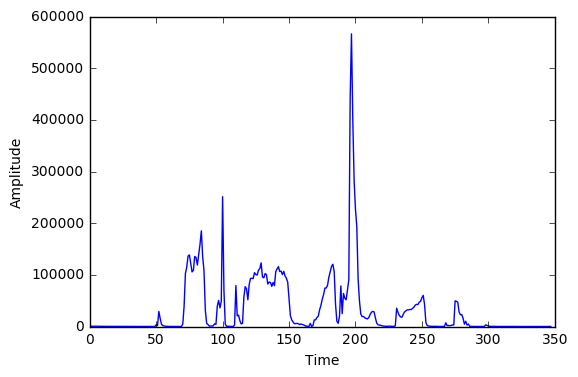

In [60]:
pow_frames = stft (frames)
print pow_frames.shape
plot_wav(np.mean(pow_frames, axis=1) )
#print np.min(pow_frames, axis=1) # np.max(pow_frames, axis=1)

In [75]:
# (Triangular) Filter Banks: 
#Apply non-linear filters to (binned) freq values to find variations between different freq bands.
# mimic the non-linear human ear perception of sound, by being more discriminative at lower frequencies
# m= 2595 * log10(1+f/700)
# nfilt = 26-40 (26 is std)

def apply_mel_filters (pow_frames, nfilt = 40, NFFT = 512):
    # create filters
    low_freq_mel = 0
    high_freq_mel = (2595 * numpy.log10(1 + (sample_rate / 2) / 700))  # Convert Hz to Mel
    mel_points = numpy.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
    hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
    bin = numpy.floor((NFFT + 1) * hz_points / sample_rate)

    fbank = numpy.zeros((nfilt, int(numpy.floor(NFFT / 2 + 1))))
    for m in range(1, nfilt + 1):
        f_m_minus = int(bin[m - 1])   # left
        f_m = int(bin[m])             # center
        f_m_plus = int(bin[m + 1])    # right

        for k in range(f_m_minus, f_m):
            fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
        for k in range(f_m, f_m_plus):
            fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
    
    #apply filters
    print 'filter shape', fbank.T.shape  # transform 257/129 sftt coeff to 40 filtered values
    filter_banks = numpy.dot(pow_frames, fbank.T)
    filter_banks = numpy.where(filter_banks == 0, numpy.finfo(float).eps, filter_banks)  # Numerical Stability
    
    filter_banks = 20 * numpy.log10(filter_banks)  # dB -- REAL LOG
    return filter_banks


In [76]:
filter_banks = apply_mel_filters (pow_frames)
print 'filter banks', filter_banks.shape

filter shape (257, 40)
filter banks (348, 40)


In [ ]:
#mean normalize filter banks
filter_banks -= (numpy.mean(filter_banks, axis=0) + 1e-8) #mean along time axis, for each freq separately

In [72]:
#MFCC - remove correlation of filter banks (WHITENING)
# Decorrelated features can be modelled efficiently as a Gaussian distribution with a diagonal covariance matrix.

# apply DCT to decorrelate, then concentrate energies in top k (13) coeff

# The reasons for discarding the other coefficients is that 
#they represent fast changes in the filter bank coefficients 
#and these fine details don’t contribute to Automatic Speech Recognition (ASR).

dct_res = dct(filter_banks, type=2, axis=1, norm='ortho')
print 'dct res', dct_res.shape
# finally keep only 'numceps' = 12 coeff
num_ceps = 12
mfcc = dct_res [:, 1 : (num_ceps + 1)] # Keep 2-13
print 'mfcc', mfcc.shape

dct res (348, 40)
mfcc (348, 12)


In [ ]:
# even more - sinusoidal filtering -- de-emphasize higher MFCCs, for noisy signals
(nframes, ncoeff) = mfcc.shape
n = numpy.arange(ncoeff)
cep_lifter = 22
lift = 1 + (cep_lifter / 2) * numpy.sin(numpy.pi * n / cep_lifter) # cep filter = 22
mfcc *= lift  #*

In [73]:
#http://dsp.stackexchange.com/questions/13/what-is-the-difference-between-a-fourier-transform-and-a-cosine-transform/17
#DFT and DCT represent a time vector using a set of basis functions -- the DFT uses a set of harmonically-related 
#complex exponential functions,
#while the DCT uses only (real-valued) cosine functions.
# DCT -- more for compression algos. the energies are concentrated in the top dimensions.

In [77]:
 ''' http://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html
 
    It is interesting to note that all steps needed to compute filter banks were motivated by the nature of the 
    speech signal and the human perception of such signals. 
    On the contrary, the extra steps needed to compute MFCCs were motivated by the limitation of some machine learning
    algorithms. The Discrete Cosine Transform (DCT) 
    was needed to decorrelate filter bank coefficients, a process also referred to as whitening
    
    May not need DCT de-correlation for deep learning. Plus, DCT may lose info.
    Hard for network to learn Fourier transform (STFT). So, keep STFT.
'''

' http://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html\n\n   It is interesting to note that all steps needed to compute filter banks were motivated by the nature of the \n   speech signal and the human perception of such signals. \n   On the contrary, the extra steps needed to compute MFCCs were motivated by the limitation of some machine learning\n   algorithms. The Discrete Cosine Transform (DCT) \n   was needed to decorrelate filter bank coefficients, a process also referred to as whitening\n   \n   May not need DCT de-correlation for deep learning. Plus, DCT may lose info.\n   \n'

In [ ]:
#Alternative for ASR: peak finding -- abstract each fft frame into 6 peaks. normalize. 
#    use this 6-bit pattern sequence to detect words by HMM
#    https://kastnerkyle.github.io/posts/single-speaker-word-recognition-with-hidden-markov-models/